# dAiv AI_Competition[2024]_Pro Baseline for PyTorch

## Import Libraries

In [ ]:
%pip install pygwalker wandb

In [ ]:
from os import path, rename, mkdir, listdir

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, utils
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pygwalker as pyg
import wandb

datasets.utils.tqdm = tqdm
%matplotlib inline

In [ ]:
# WandB Initialization
wandb.init(project="dAiv-ai-competition-2024-pro")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: brew (brew-research). Use `wandb login --relogin` to force relogin


### Check GPU Availability

In [ ]:
!nvidia-smi

Mon Oct 14 04:16:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |


In [ ]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 0

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
print("INFO: Using device -", device)

INFO: Using device - cuda


## Load DataSets

In [ ]:
from typing import Callable, Optional
from sklearn.model_selection import train_test_split


class ImageDataset(datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_pro/dataset/archive.zip"
    random_state = 20241028

    def __init__(
            self, root: str, force_download: bool = True,
            train: bool = False, valid: bool = False, split_ratio: float = 0.8,
            test: bool = False, unlabeled: bool = False,
            transform: Optional[Callable] = None, target_transform: Optional[Callable] = None
    ):
        self.download(root, force=force_download)  # Download Dataset from server

        if train or valid:  # Set-up directory
            root = path.join(root, "train")
        else:
            root = path.join(root, "test" if test else "unlabeled" if unlabeled else None)

        # Initialize ImageFolder
        super().__init__(root=root, transform=transform, target_transform=target_transform)

        if train or valid:  # Split Train and Validation Set
            seperated = train_test_split(
                self.samples, self.targets, test_size=1-split_ratio, stratify=self.targets, random_state=self.random_state
            )
            self.samples, self.targets = (seperated[0], seperated[2]) if train else (seperated[1], seperated[3])
            self.imgs = self.samples

    @property
    def df(self) -> pd.DataFrame:
        return pd.DataFrame(dict(path=[d[0] for d in self.samples], label=[self.classes[lb] for lb in self.targets]))

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "archive.zip")):
            # Download and Extract Dataset
            datasets.utils.download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="archive.zip")

            # Arrange Dataset Directory
            for target_dir in [path.join(root, "test"), path.join(root, "unlabeled")]:
                for file in listdir(target_dir):
                    mkdir(path.join(target_dir, file.replace(".jpg", "")))
                    rename(path.join(target_dir, file), path.join(target_dir, file.replace(".jpg", ""), file))

            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

### Dataset Initialization

In [ ]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (256, 256)
IMG_NORM = dict(  # ImageNet Normalization
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [ ]:
DATA_ROOT = path.join(".", "data")

train_dataset = ImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = ImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)

test_dataset = ImageDataset(root=DATA_ROOT, force_download=False, test=True, transform=resizer)
unlabeled_dataset = ImageDataset(root=DATA_ROOT, force_download=False, unlabeled=True, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)}), Unlabeled({len(unlabeled_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(7478), Valid(1870), Test(1110), Unlabeled(380)


### Visualize Dataset Distribution
    - for checking...

In [ ]:
# Label Check
for i, label in zip(range(5), train_dataset.targets):
    print(i, "-", train_dataset.classes[label])

0 - 050.Pelagic_Cormorant
1 - 020.Leonberger
2 - 104.Black_capped_Vireo
3 - 020.Leonberger
4 - 009.Siamese


In [ ]:
# Data Check
for i, image in zip(range(2), train_dataset.samples):
    print(i, "-", *train_dataset[i], image[0])

0 - tensor([[[ 0.5364,  0.5536,  0.5536,  ...,  0.7419,  0.7077,  0.7077],
         [ 0.5364,  0.5536,  0.5536,  ...,  0.7419,  0.7077,  0.7077],
         [ 0.5536,  0.5536,  0.5536,  ...,  0.7419,  0.7248,  0.7248],
         ...,
         [ 1.3070,  1.1872,  1.1358,  ...,  0.9988,  1.1015,  0.8104],
         [ 1.2043,  1.1872,  1.1015,  ...,  0.7419,  0.6392,  0.4851],
         [ 1.0844,  1.1187,  1.0673,  ...,  0.7248,  0.6734,  1.0331]],

        [[ 0.3978,  0.4153,  0.4328,  ...,  0.5028,  0.4678,  0.4328],
         [ 0.3978,  0.4153,  0.4153,  ...,  0.5028,  0.4853,  0.4503],
         [ 0.3803,  0.3803,  0.4153,  ...,  0.5028,  0.4853,  0.4503],
         ...,
         [ 1.0455,  0.9230,  0.8880,  ...,  0.7829,  0.8704,  0.5553],
         [ 0.9755,  0.9580,  0.9055,  ...,  0.5553,  0.3627,  0.1176],
         [ 0.8529,  0.9055,  0.8880,  ...,  0.5378,  0.3803,  0.6779]],

        [[ 0.2348,  0.2348,  0.2522,  ...,  0.3045,  0.2522,  0.1999],
         [ 0.2173,  0.2348,  0.2348,  ...

In [ ]:
train_dataset.df

,path,label
0,.\data\train\050.Pelagic_Cormorant\016.jpg,050.Pelagic_Cormorant
1,.\data\train\020.Leonberger\162.jpg,020.Leonberger
2,.\data\train\104.Black_capped_Vireo\030.jpg,104.Black_capped_Vireo
3,.\data\train\020.Leonberger\059.jpg,020.Leonberger
4,.\data\train\009.Siamese\120.jpg,009.Siamese
...,...,...
7473,.\data\train\023.Pomeranian\061.jpg,023.Pomeranian
7474,.\data\train\019.Keeshond\013.jpg,019.Keeshond
7475,.\data\train\012.Boxer\156.jpg,012.Boxer
7476,.\data\train\039.Brewer_Blackbird\009.jpg,039.Brewer_Blackbird


In [ ]:
# Train Dataset Distribution
pyg.walk(train_dataset.df)

Box(children=(HTML(value='\n<div id="ifr-pyg-00062460903a1e94F8iRUhXQyC5JOErm" style="height: auto">\n    <hea…

In [ ]:
valid_dataset.df

,path,label
0,.\data\train\071.Evening_Grosbeak\034.jpg,071.Evening_Grosbeak
1,.\data\train\066.Eared_Grebe\004.jpg,066.Eared_Grebe
2,.\data\train\118.Rock_Wren\033.jpg,118.Rock_Wren
3,.\data\train\035.Groove_billed_Ani\022.jpg,035.Groove_billed_Ani
4,.\data\train\008.Russian_Blue\098.jpg,008.Russian_Blue
...,...,...
1865,.\data\train\012.Boxer\000.jpg,012.Boxer
1866,.\data\train\016.Great_Pyrenees\003.jpg,016.Great_Pyrenees
1867,.\data\train\024.Pug\027.jpg,024.Pug
1868,.\data\train\005.Egyptian_Mau\134.jpg,005.Egyptian_Mau


In [ ]:
# Valid Dataset Distribution
walker = pyg.walk(valid_dataset.df, theme_key="streamlit")

Box(children=(HTML(value='\n<div id="ifr-pyg-000624609041d2dbobrQHNXaRYCZIg3B" style="height: auto">\n    <hea…

## Data Augmentation if needed

In [ ]:
ROTATE_ANGLE = 20
COLOR_TRANSFORM = 0.1

In [ ]:
augmenter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATE_ANGLE),
    transforms.ColorJitter(
        brightness=COLOR_TRANSFORM, contrast=COLOR_TRANSFORM,
        saturation=COLOR_TRANSFORM, hue=COLOR_TRANSFORM
    ),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    resizer
])

In [ ]:
train_dataset = ImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(7478)


## DataLoader

In [ ]:
# Set Batch Size
BATCH_SIZE = 128

In [ ]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

INFO: Using DataLoader without multi-processing.


In [ ]:
# Image Visualizer
def imshow(image_list, mean=IMG_NORM['mean'], std=IMG_NORM['std']):
    np_image = np.array(image_list).transpose((1, 2, 0))
    de_norm_image = np_image * std + mean
    plt.figure(figsize=(10, 10))
    plt.imshow(de_norm_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


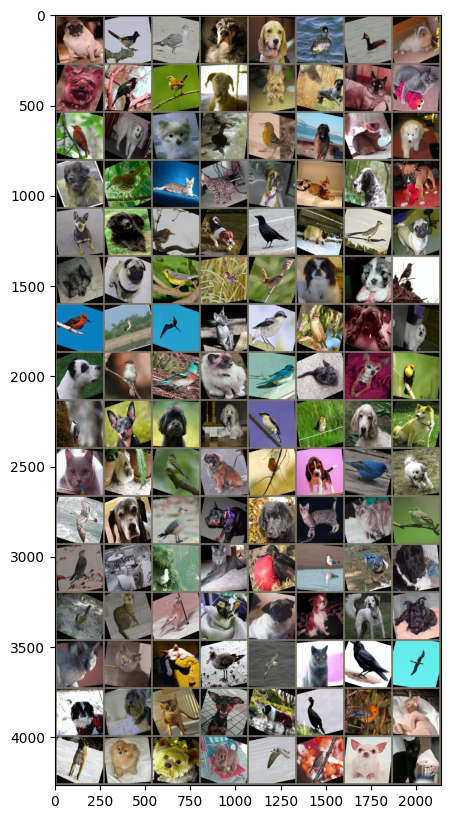

In [ ]:
images, targets = next(iter(train_loader))
grid_images = utils.make_grid(images, nrow=8, padding=10)
imshow(grid_images)

## Define Model

In [ ]:
class SecondMaxLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.clone()
        max_val, max_idx = torch.max(x, dim=1, keepdim=True)
        x.scatter_(1, max_idx, 1e-12)
        return x

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, input_channel: int, output_channel: int, adaptive_pool_size: int, img_size: int, num_classes: int):
        super().__init__()
        self.multiple_output = False

        # Feature Extractor
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_channel//4, out_channels=output_channel//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(output_channel//4)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//4, out_channels=output_channel//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_channel//2, out_channels=output_channel//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(output_channel//2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//2, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(output_channel)
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        # Assuming you want to connect to a fully connected layer after flattening
        # Calculate the size of the flattened features after 3 pooling layers
        self.fc_size = output_channel * (img_size // 2**3) * (img_size // 2**3)
        self.fc = nn.Linear(self.fc_size, adaptive_pool_size)

        # Adaptive Layer
        self.adaptive_layer = nn.Sequential(
            nn.Linear(adaptive_pool_size, adaptive_pool_size),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.domain_classifier = nn.Linear(adaptive_pool_size, 1)  # Train domain or Test domain

        # Output Layer
        self.classifier = nn.Linear(adaptive_pool_size, num_classes)
        self.secondary = SecondMaxLayer()  # For multi-label classification

    def toggle_multilabel(self, multi_label: bool | None = None):
        if isinstance(multi_label, bool):
            self.multiple_output = multi_label
        else:
            self.multiple_output = not self.multiple_output

    def forward(self, x) -> tuple[torch.Tensor, torch.Tensor] | tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Feature Extracting
        h1 = self.layer1(x)
        h2 = self.layer2(h1)
        h3 = self.layer3(h2)
        h3 = h3.view(h3.size(0), -1)  # Flatten the output for the fully connected layer
        extracted = self.fc(h3)

        # Adaptive Layer
        adapted = self.adaptive_layer(extracted)

        # Output Layer
        out = self.classifier(adapted)
        domain = torch.sigmoid(self.domain_classifier(adapted))  # Logits
        if self.multiple_output:
            return domain, out, self.secondary(out)
        return domain, out

In [ ]:
CLASS_LABELS = len(train_dataset.classes)

MODEL_PARAMS = dict(
    input_channel=3, output_channel=64, adaptive_pool_size=512,
    img_size=IMG_SIZE[0], num_classes=CLASS_LABELS
)

In [ ]:
# Initialize Model
model = ImageClassifier(**MODEL_PARAMS)
model.to(device)

ImageClassifier(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2

In [ ]:
LEARNING_RATE = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

## Training Loop

In [ ]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [ ]:
wandb.watch(model, criterion, log="all", log_freq=10)

[]

In [ ]:
# Set Epoch Count
num_epochs = 50

In [ ]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(num_epochs), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        # Training
        model.train()
        model.toggle_multilabel(False)
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            domain_outputs, outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            update(loss)
            train_progress.update(1)
            if i != train_length-1: wandb.log({'Loss': loss.item()})
            print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{i+1:2}/{train_length}], Loss: {loss.item():.6f}", end="")

        val_acc, val_loss = 0, 0

        # Validation
        model.eval()
        model.toggle_multilabel(False)
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                domain_outputs, outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / len(valid_dataset)
                valid_progress.update(1)

        wandb.log({'Loss': loss.item(), 'Val Acc': val_acc, 'Val Loss': val_loss})
        print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == num_epochs else "")

Running Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Output()

Epoch [ 5/50], Step [ 6/59], Loss: 3.499440, Valid Acc: 16.844921%, Valid Loss: 3.492229

In [ ]:
if not path.isdir(path.join(".", "models")):
    mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"baseline_model.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Model Evaluation

In [ ]:
# Load Model
model_id = "baseline_model"

model = ImageClassifier(**MODEL_PARAMS)
model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [ ]:
results = dict(id=[], label1=[], label2=[])
test_length = len(test_dataset)

model.eval()
model.toggle_multilabel(True)
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        _, outputs1, outputs2 = model(inputs)
        preds1, preds2 = torch.max(outputs1, 1)[1], torch.max(outputs2, 1)[1]
        results['id'] += [test_dataset.classes[i] for i in ids]
        results['label1'] += preds1.cpu().detach().numpy().tolist()
        results['label2'] += preds2.cpu().detach().numpy().tolist()

In [ ]:
# Re-arrange Results
for i, labels in enumerate(zip(results['label1'], results['label2'])):
    results['label1'][i], results['label2'][i] = min(labels), max(labels)

results_df = pd.DataFrame(results)
results_df

In [ ]:
# Save Results
submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"{model_id}.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)